## Author: Caio Avelino
* [LinkedIn](https://www.linkedin.com/in/caioavelino/)
* [Kaggle](https://www.kaggle.com/avelinocaio)

## Project Phases:
> 
* **0) Libraries and Data Loading**
* **1) Exploratory Analysis and Data Cleaning**
* **2) Feature Importance**
* **3) Train Model**
* **4) Voting**
* **5) Submission**

# 0-Libraries and Data Loading

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore") # ignoring annoying warnings

> Ignoring warnings that are not relevant for this project.

In [6]:
warnings.filterwarnings("ignore")

> Loading data.

In [7]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
test["Survived"] = np.nan # we don't have target values for the test

> Here we concat train and test into one, so we can analyze everything and replace nan values later based on all dataset.

In [8]:
dataset = pd.concat([train,test],axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

# 1-Exploratory Analysis and Data Cleaning

In [9]:
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


> Let's see the dataset types, nan quantity for each column and describe them.

In [10]:
dataset.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
dataset.isnull().sum(axis = 0)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

> **Age**, **Cabin**, **Fare** and **Embarked** have nan values. 
We will need to analyze each feature individually to get better results.
**Survived** has nan values just because of test data.

In [12]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


> This results shows that probably **Fare**, for example, has outliers, since its maximum value is so much higher than 75% of the data. Also the mean is very different from median (50%).

### SibSp and Parch

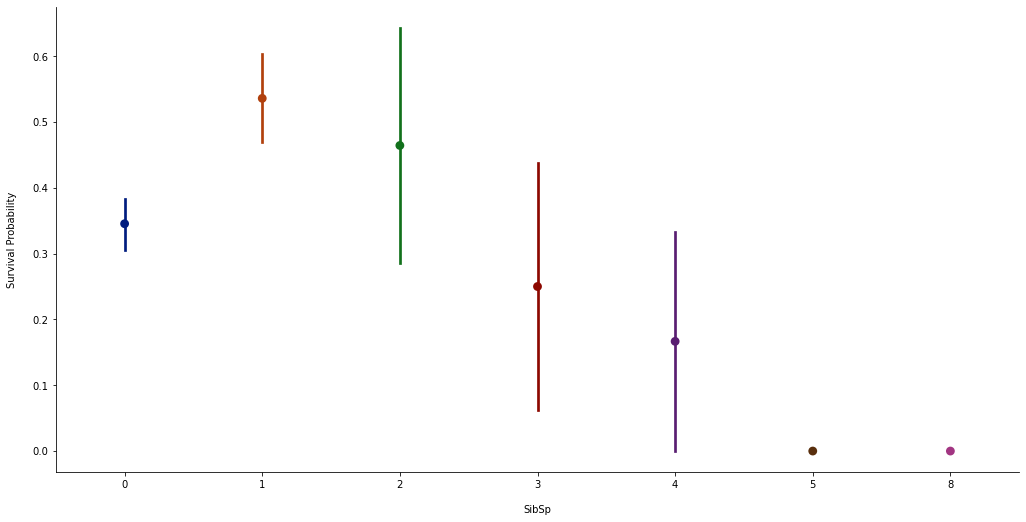

In [13]:
sns.factorplot(x='SibSp', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nSibSp')
plt.ylabel('Survival Probability\n')
plt.show()

> Small numbers of SibSp have higher probability to survive.

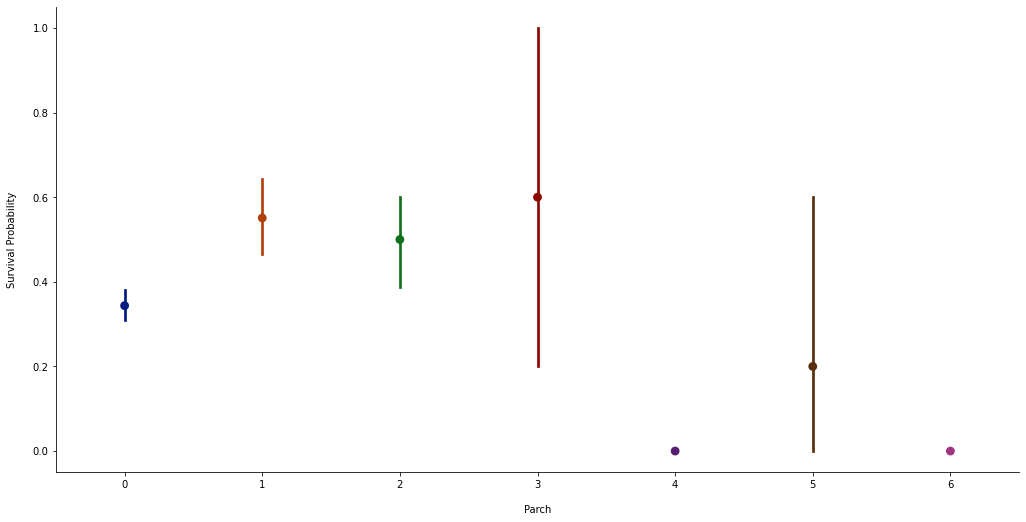

In [14]:
sns.factorplot(x='Parch', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nParch')
plt.ylabel('Survival Probability\n')
plt.show()

> Small numbers of Parch have higher probability to survive.

> Since these features have similar behavior, then we can add them with each person being analyzed.

In [15]:
dataset["Family"] = dataset["SibSp"] + dataset["Parch"] + 1
train["Family"] = train["SibSp"] + train["Parch"] + 1
test["Family"] = test["SibSp"] + test["Parch"] + 1

> Repeating the factorplot for the Family.

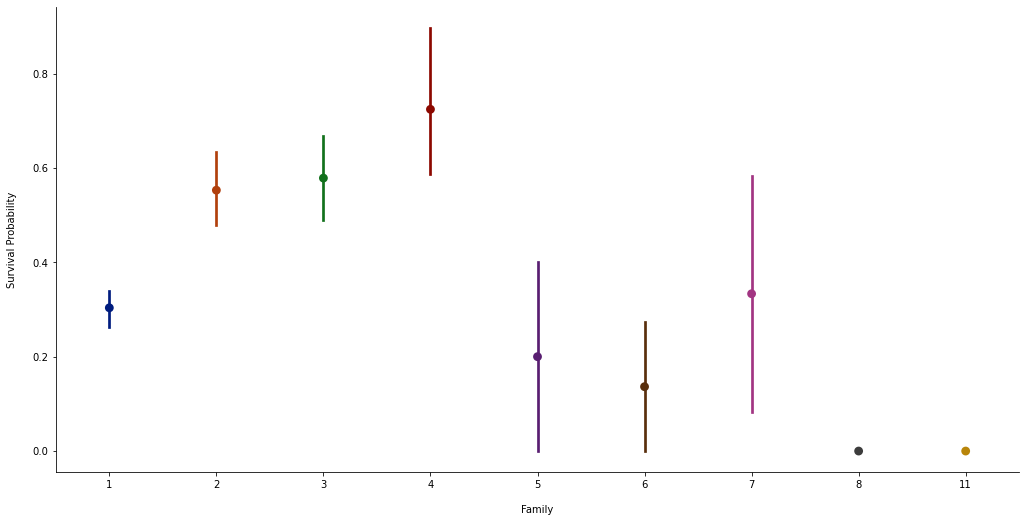

In [16]:
sns.factorplot(x='Family', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived', 
               palette = "dark")
plt.xlabel('\nFamily')
plt.ylabel('Survival Probability\n')
plt.show()

> we don't need these features anymore, since we created another one.

In [17]:
dataset = dataset.drop(columns=["SibSp","Parch"])
train = train.drop(columns=["SibSp","Parch"])
test = test.drop(columns=["SibSp","Parch"])

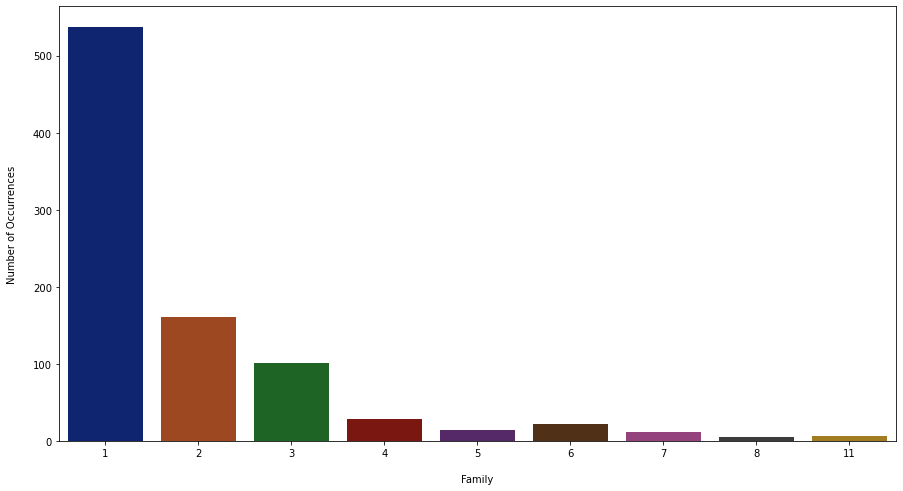

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(data=train,
              x='Family',
              palette = "dark")
plt.xlabel('\nFamily')
plt.ylabel('Number of Occurrences\n')
plt.show()

> The countplot shows that the more families grow, the fewer occurrences happen.

> Since there are 11 different categories for Family, lets group them in single, medium and big families.

In [19]:
dataset.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), dataset.Family))
train.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), train.Family))
test.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), test.Family))

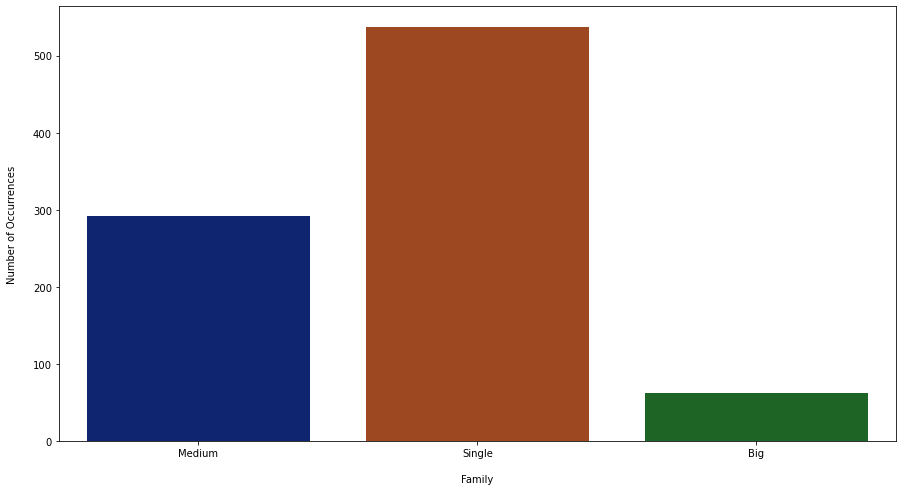

In [20]:
plt.figure(figsize=(15,8))
sns.countplot(data=train,
              x='Family',
              palette = "dark")
plt.xlabel('\nFamily')
plt.ylabel('Number of Occurrences\n')
plt.show()

> Now we have 3 categories.

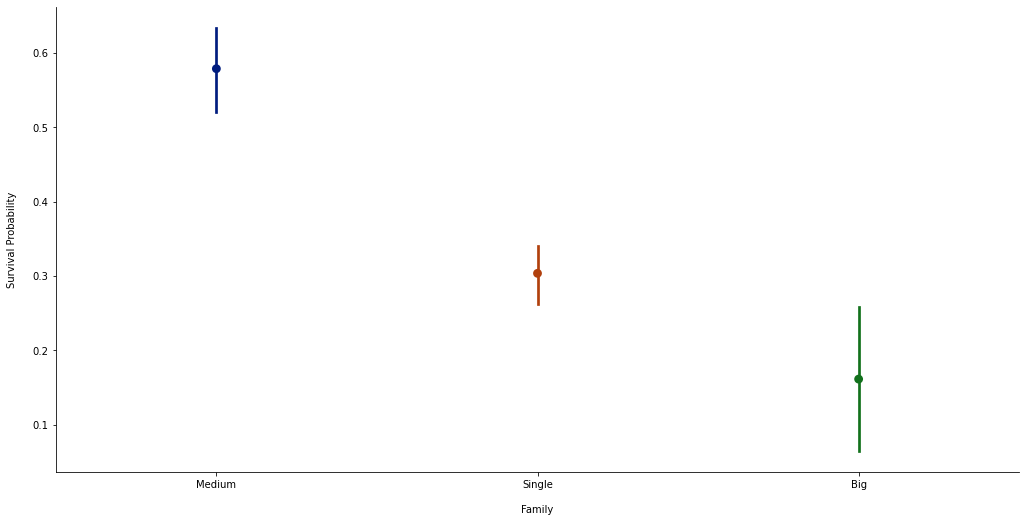

In [21]:
sns.factorplot(x='Family', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nFamily')
plt.ylabel('Survival Probability\n')
plt.show()

### Sex

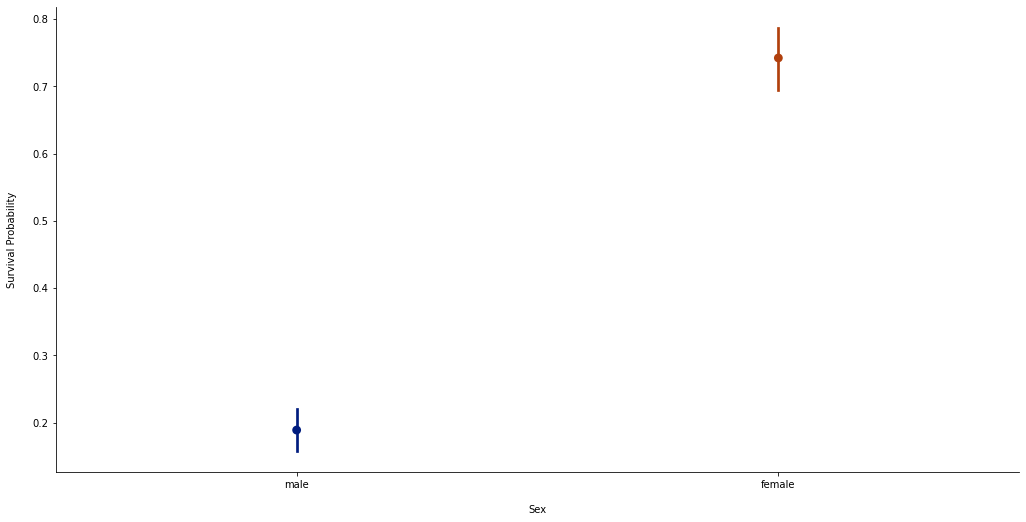

In [22]:
sns.factorplot(x='Sex', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nSex')
plt.ylabel('Survival Probability\n')
plt.show()

> This clearly shows that a woman has higher probability to survive.

> Many models need to receive numbers, not text. So, let's change **sex** from string to integer type.


In [23]:
dataset.Sex = dataset.Sex.map({'male': 0, 'female': 1})
train.Sex = train.Sex.map({'male': 0, 'female': 1})
test.Sex = test.Sex.map({'male': 0, 'female': 1})

### Pclass

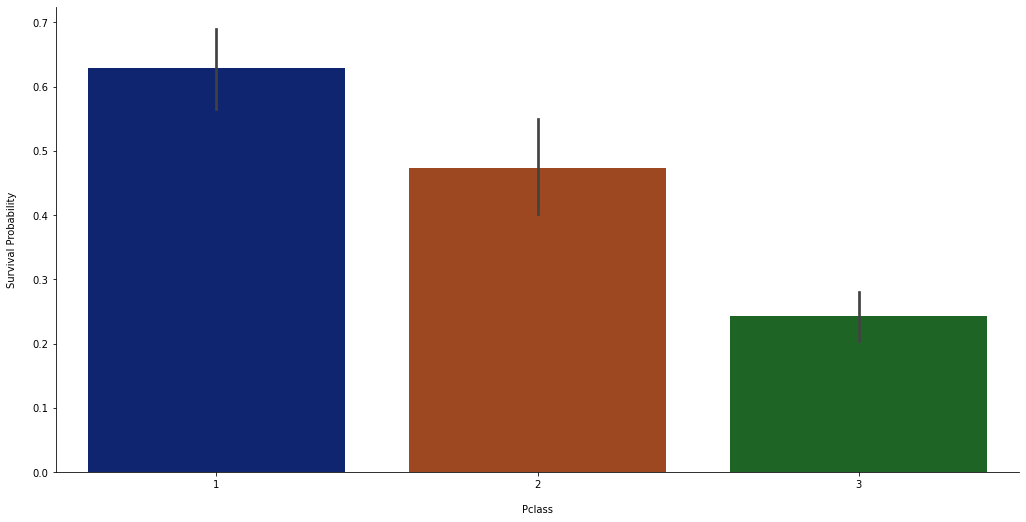

In [24]:
sns.factorplot(x='Pclass', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               kind='bar',
               palette = "dark")
plt.xlabel('\nPclass')
plt.ylabel('Survival Probability\n')
plt.show()

> This shows that first class has higher probability to survive, probably because of influence.

### Fare

> Since we have not so many nan values for this feature, then we can use the dataset median to fill them.

In [25]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
train["Fare"] = train["Fare"].fillna(dataset["Fare"].median())
test["Fare"] = test["Fare"].fillna(dataset["Fare"].median())

> **Fare** can be considered as continuous variable, so we can plot its distribution.

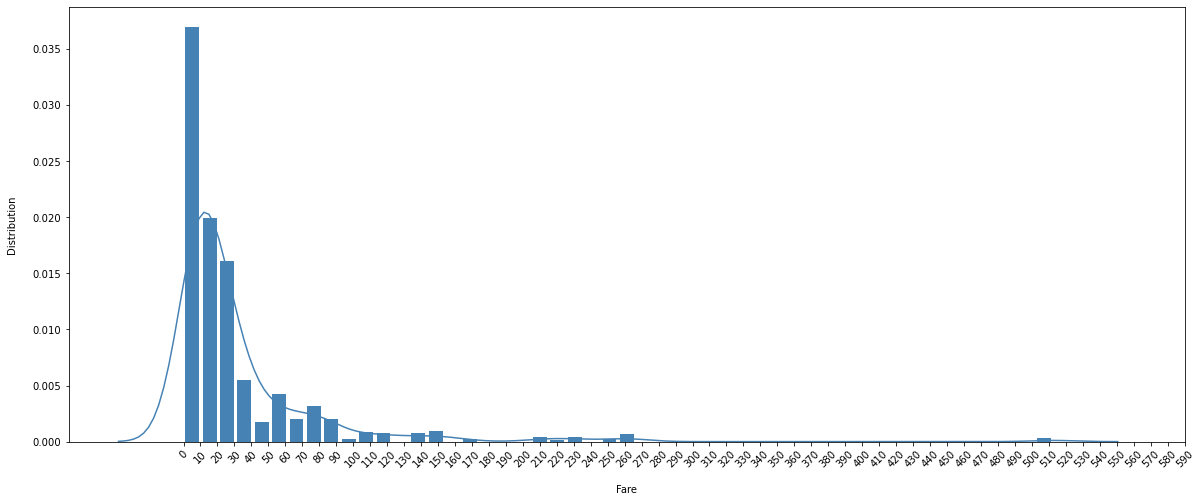

In [26]:
plt.figure(figsize=(20,8))
sns.distplot(train['Fare'], color = "steelblue", hist_kws={"rwidth":0.80, 'alpha':1.0})
plt.xticks(np.arange(0,600,10),rotation=45)
plt.xlabel('\nFare')
plt.ylabel('Distribution\n')
plt.show()

> It seems that the curve has a positive skewness (to the left).

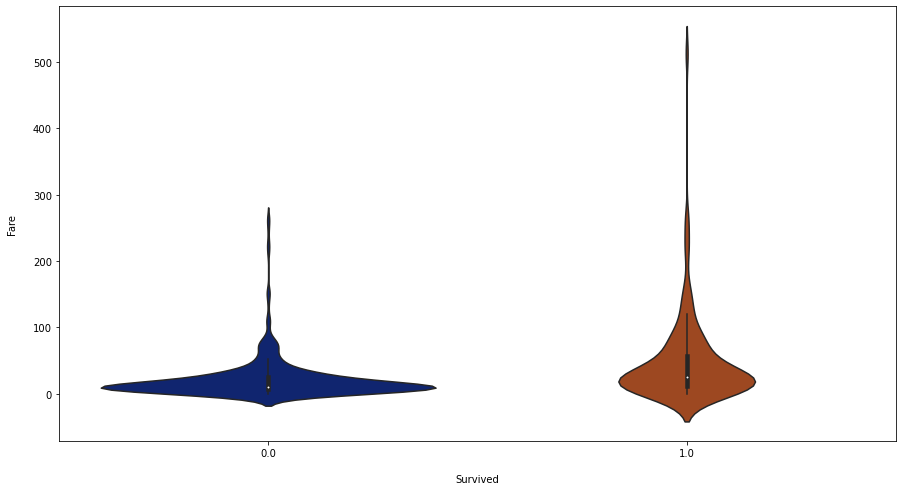

In [27]:
plt.figure(figsize=(15,8))
sns.violinplot(y='Fare',
            data=dataset,
            x='Survived',
            palette = "dark")
plt.xlabel('\nSurvived')
plt.ylabel('Fare\n')
plt.show()

> Probably the people who payed more have higher probability to suvive, but there aren't many.

> Let's divide *Fare* in categories, first we need to create balanced category shapes.

In [28]:
dataset[dataset.Fare.between(0,10)].shape

(491, 11)

In [29]:
dataset[dataset.Fare.between(11,25)].shape

(291, 11)

In [30]:
dataset[dataset.Fare.between(26,50)].shape

(236, 11)

In [31]:
dataset[dataset.Fare > 51].shape

(238, 11)

> So, lets divide the feature values into 3 categories, with similiar shape.

In [32]:
dataset.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), dataset.Fare))

train.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), train.Fare))

test.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), test.Fare))

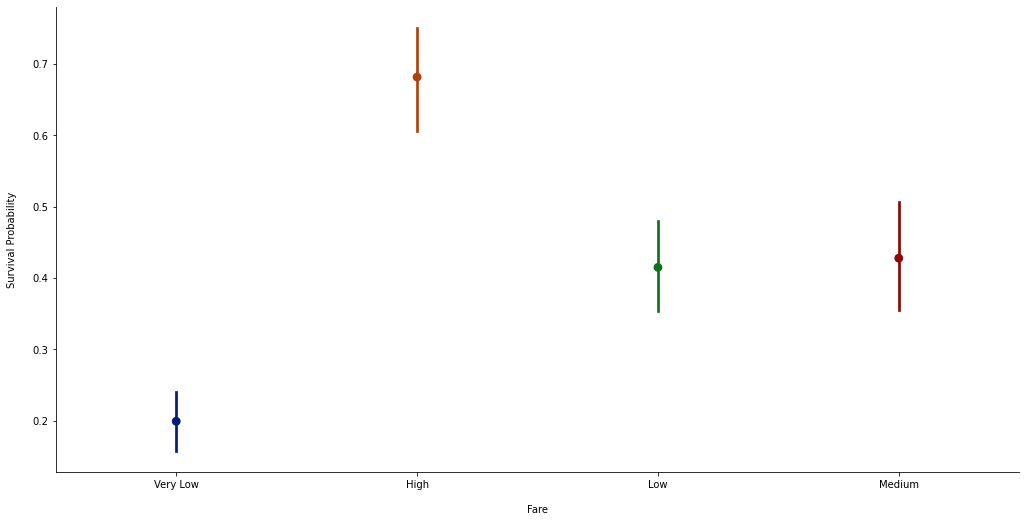

In [33]:
sns.factorplot(x='Fare', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nFare')
plt.ylabel('Survival Probability\n')
plt.show()

> Here we can see that high fare people have higher probability to survive, and very low fare people have not.

### Embarked

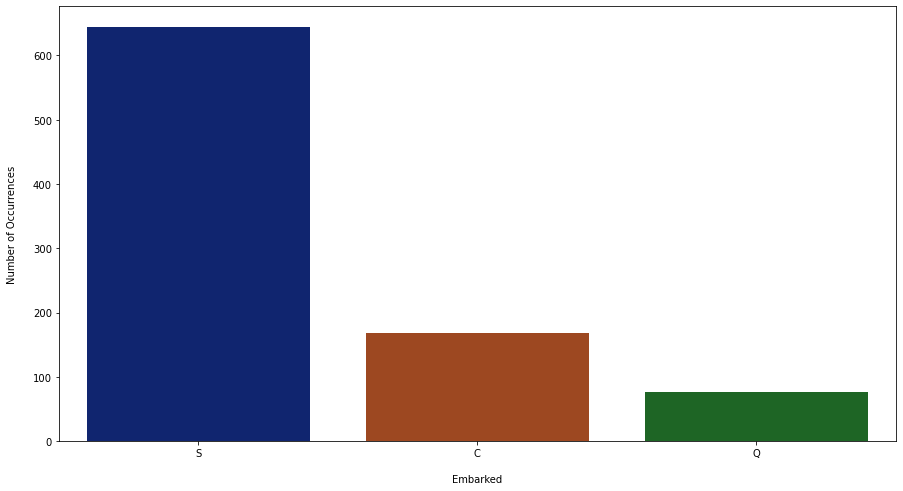

In [34]:
plt.figure(figsize=(15,8))
sns.countplot(x='Embarked', 
               data=train, 
               palette = "dark")
plt.xlabel('\nEmbarked')
plt.ylabel('Number of Occurrences\n')
plt.show()

> 'S' ir more frequent in the dataset.

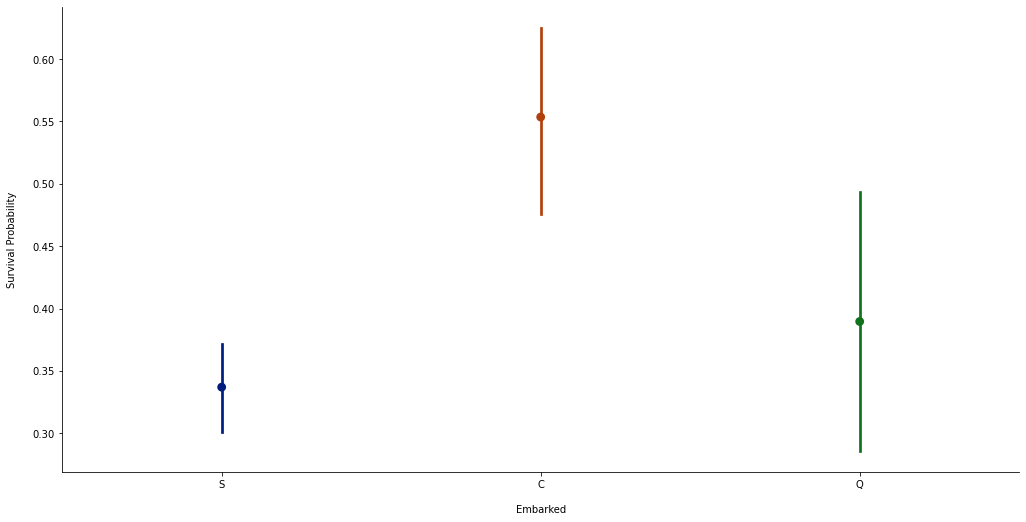

In [35]:
sns.factorplot(x='Embarked', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nEmbarked')
plt.ylabel('Survival Probability\n')
plt.show()

> Another variable that shows a difference in survival probability.

> We are going to fill the two nan values with the most frequent category.

In [36]:
dataset.Embarked = dataset.Embarked.fillna('S')
train.Embarked = train.Embarked.fillna('S')
test.Embarked = test.Embarked.fillna('S')

### Name

> Getting the title (Mr, Mrs, Miss and others) which is present in all rows and creating another column.

In [37]:
title = []
for i in dataset.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
dataset["Title"] = title

title = []
for i in train.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
train["Title"] = title

title = []
for i in test.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
test["Title"] = title

> Dropping **Name** column that we don't need anymore.

In [38]:
dataset = dataset.drop(columns=["Name"])
train = train.drop(columns=["Name"])
test = test.drop(columns=["Name"])

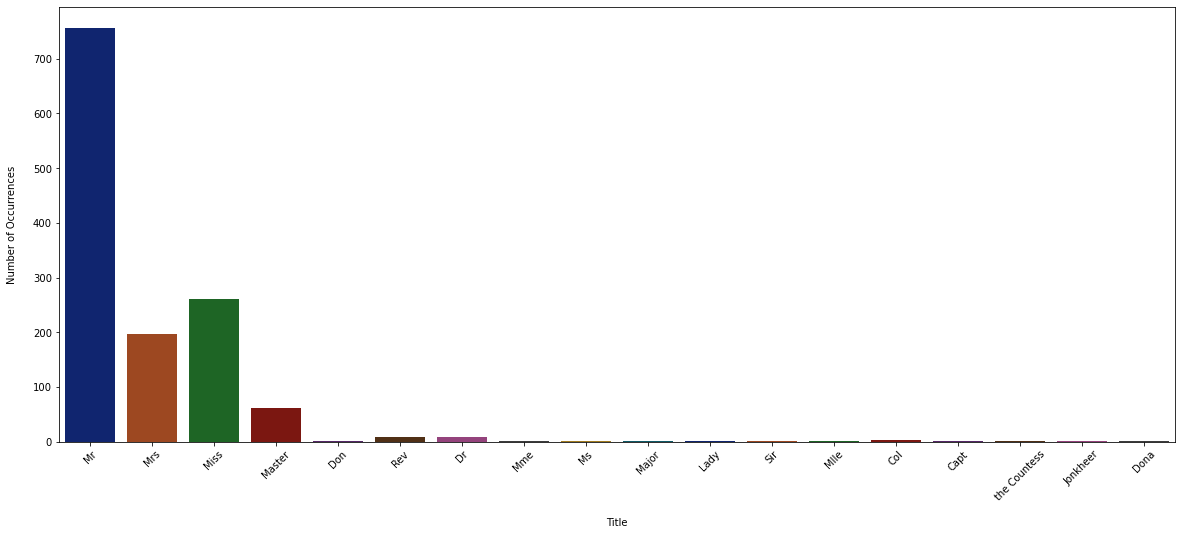

In [39]:
plt.figure(figsize=(20,8))
sns.countplot(dataset.Title, palette = "dark")
plt.xticks(rotation=45)
plt.xlabel('\nTitle')
plt.ylabel('Number of Occurrences\n')
plt.show()

> Titles frequency: we can see that the majority of the people has titles like 'Mr', 'Mrs' and 'Miss'. We can group the others into one category.

In [40]:
dataset.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else('Other'), dataset.Title))

train.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else('Other'), train.Title))

test.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else 'Other', test.Title))

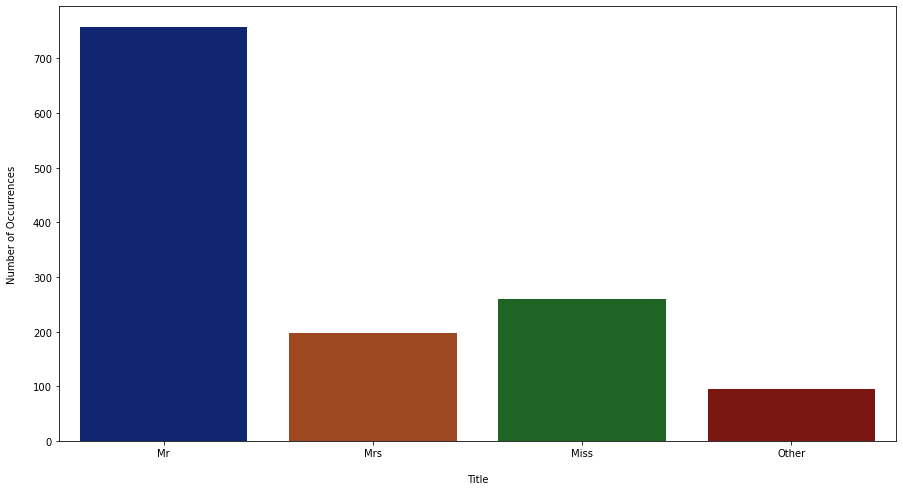

In [41]:
plt.figure(figsize=(15,8))
sns.countplot(dataset.Title, palette = "dark")
plt.xlabel('\nTitle')
plt.ylabel('Number of Occurrences\n')
plt.show()

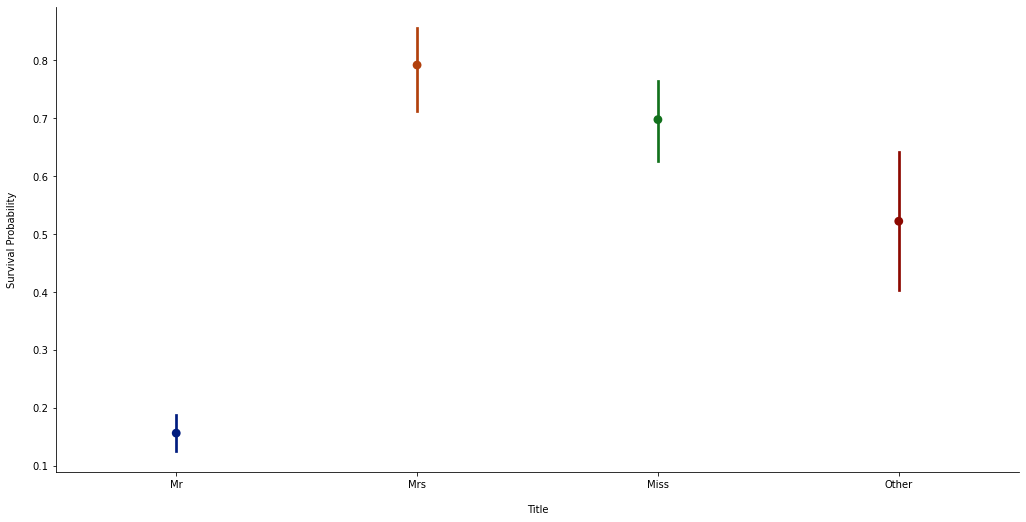

In [42]:
sns.factorplot(x='Title', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nTitle')
plt.ylabel('Survival Probability\n')
plt.show()

> Clearly the gentlemen are in danger.

### Cabin

> This variable doesn't seem to have a lot of value except the first letter. 
So let's extract it, if nan then let the letter be 'Z'.

In [43]:
cabin = []
for i in dataset.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
dataset.Cabin = cabin

cabin = []
for i in train.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
train.Cabin = cabin

cabin = []
for i in test.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
test.Cabin = cabin

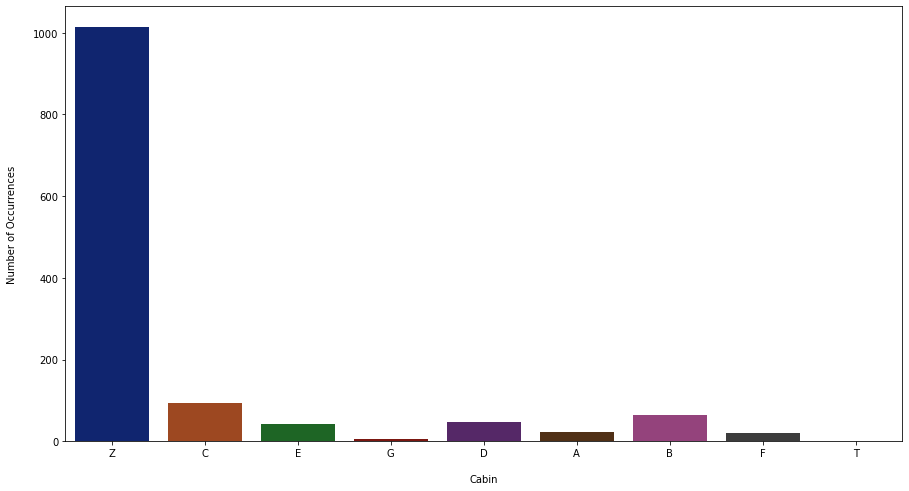

In [44]:
plt.figure(figsize=(15,8))
sns.countplot(dataset.Cabin, palette = "dark")
plt.xlabel('\nCabin')
plt.ylabel('Number of Occurrences\n')
plt.show()

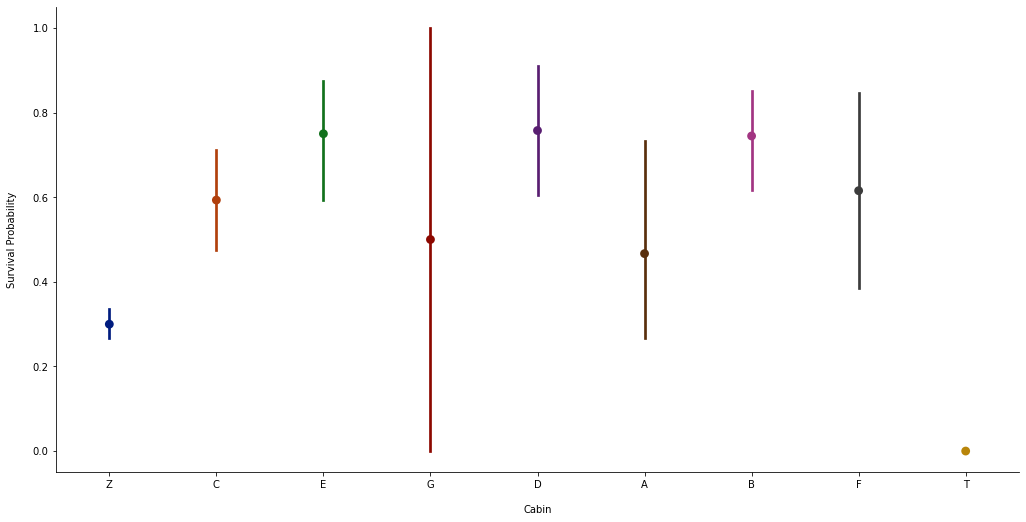

In [45]:
sns.factorplot(x='Cabin', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nCabin')
plt.ylabel('Survival Probability\n')
plt.show()

> It seems that people without cabines have less chance to survive, but standard deviations are large for some letters. We can group letters with similar behaviors.

In [46]:
dataset.Cabin = dataset.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})
train.Cabin = train.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})
test.Cabin = test.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})

> Counting them again, by group.

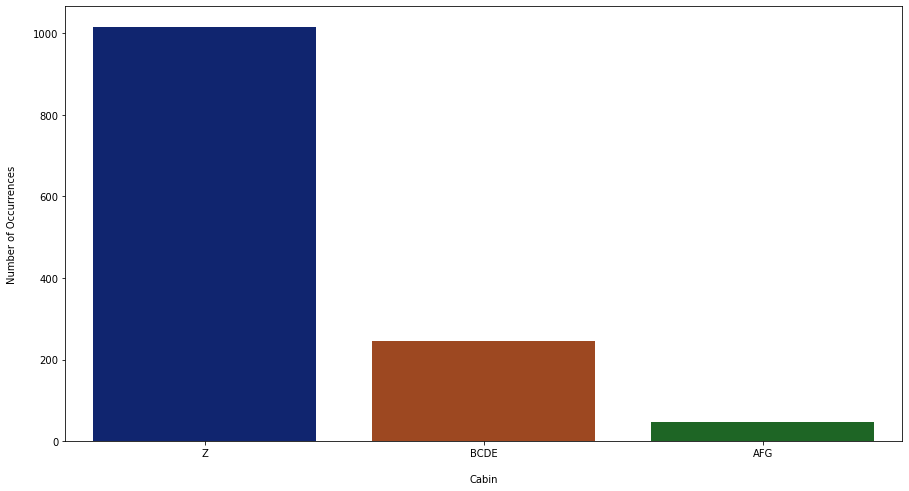

In [47]:
plt.figure(figsize=(15,8))
sns.countplot(dataset.Cabin, palette = "dark")
plt.xlabel('\nCabin')
plt.ylabel('Number of Occurrences\n')
plt.show()

> New factorplot.

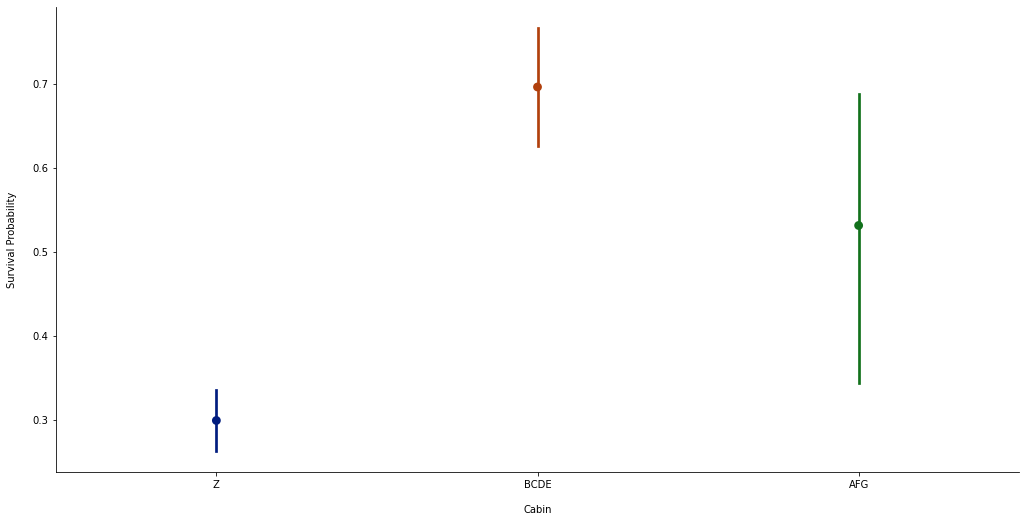

In [48]:
sns.factorplot(x='Cabin', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nCabin')
plt.ylabel('Survival Probability\n')
plt.show()

### Ticket

> This variable also doesn't seem to have a lot of value except the first number.

In [49]:
tickets = []
for i in dataset.Ticket:
    tickets.append(i.split(' ')[-1][0])
dataset.Ticket = tickets

tickets = []
for i in train.Ticket:
    tickets.append(i.split(' ')[-1][0])
train.Ticket = tickets

tickets = []
for i in test.Ticket:
    tickets.append(i.split(' ')[-1][0])
test.Ticket = tickets

> Let's see the number of occurrences for each number.

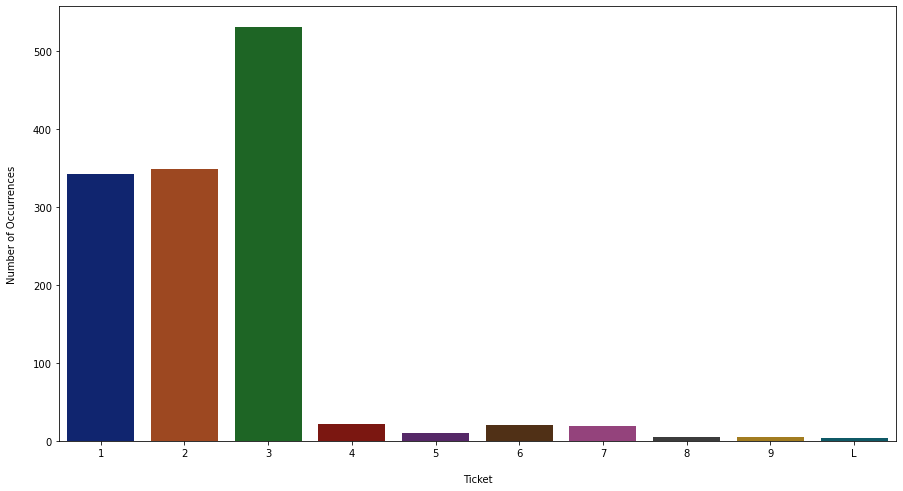

In [50]:
plt.figure(figsize=(15,8))
sns.countplot(dataset.Ticket.sort_values(), palette = "dark")
plt.xlabel('\nTicket')
plt.ylabel('Number of Occurrences\n')
plt.show()

> The more frequent numbers are 1, 2 and 3.

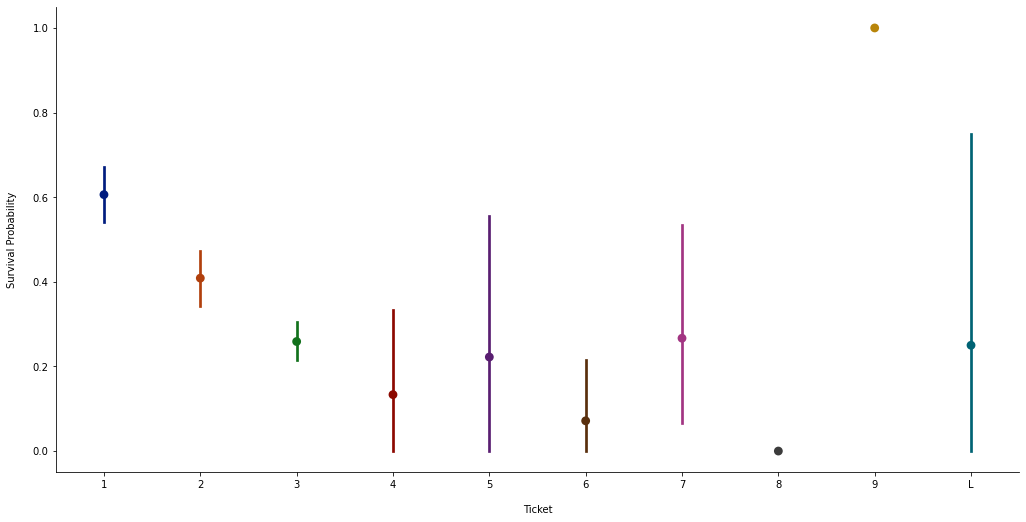

In [51]:
sns.factorplot(x='Ticket', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark",
               order=train.Ticket.sort_values().unique())
plt.xlabel('\nTicket')
plt.ylabel('Survival Probability\n')
plt.show()

> Since 1, 2 and 3 have more occurrences and the others have large standard deviations, we can group these into one category.

In [52]:
dataset.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), dataset.Ticket))
train.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), train.Ticket))
test.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), test.Ticket))

> New countplot.

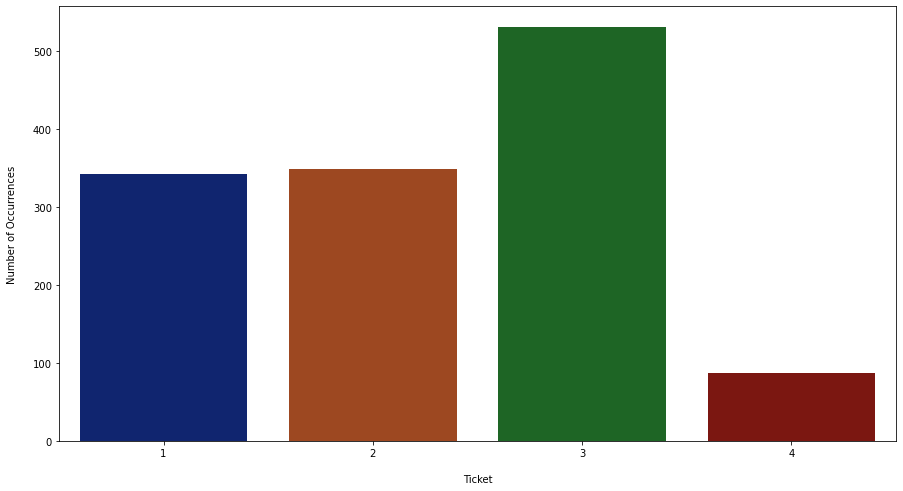

In [53]:
plt.figure(figsize=(15,8))
sns.countplot(dataset.Ticket.sort_values(), palette = "dark")
plt.xlabel('\nTicket')
plt.ylabel('Number of Occurrences\n')
plt.show()

> And now we have 4 categories, with different probabilities.

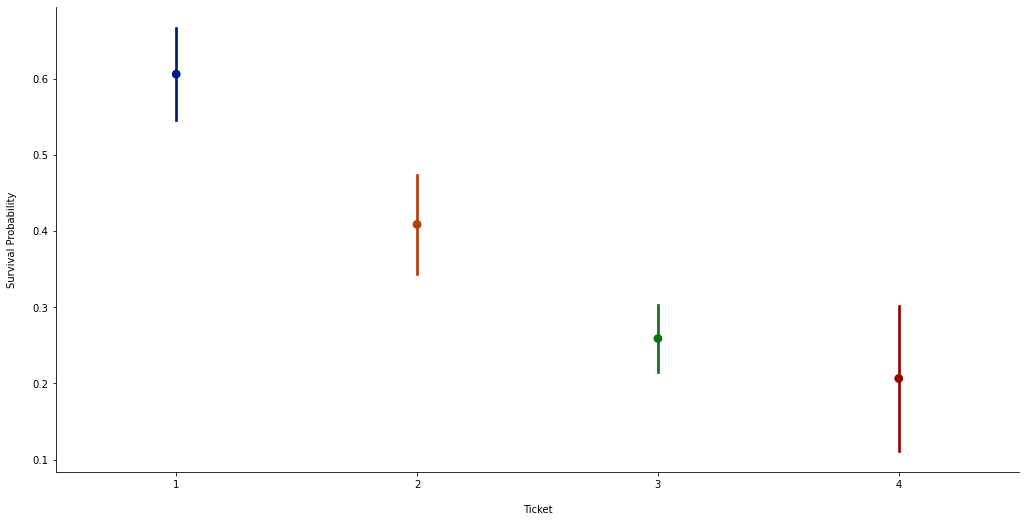

In [54]:
sns.factorplot(x='Ticket', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark",
               order=train.Ticket.sort_values().unique())
plt.xlabel('\nTicket')
plt.ylabel('Survival Probability\n')
plt.show()

### Age

> We will need to see which features have more correlation with age, so we can safely replace nan values.

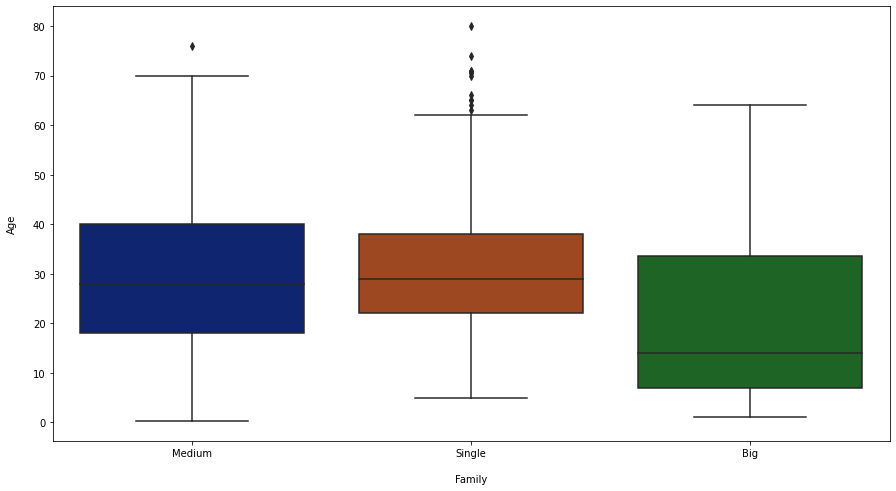

In [55]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Family', data=dataset,y='Age', palette = "dark")
plt.xlabel('\nFamily')
plt.ylabel('Age\n')
plt.show()

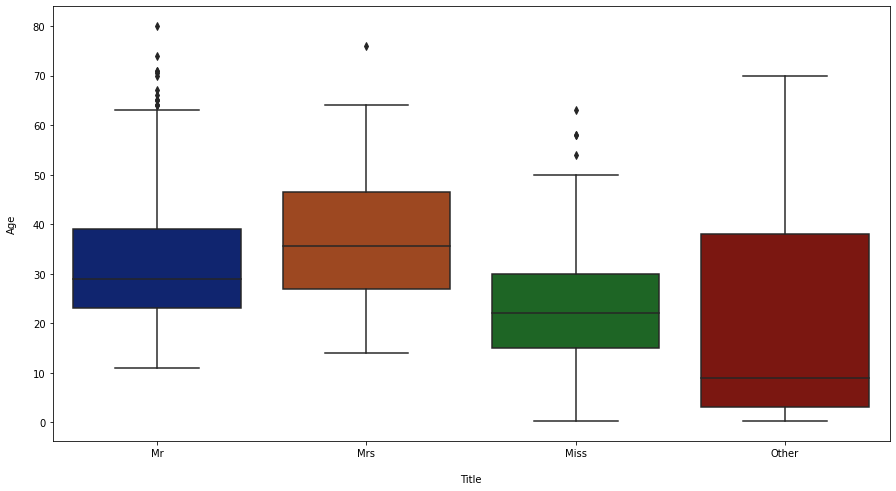

In [56]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Title',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nTitle')
plt.ylabel('Age\n')
plt.show()

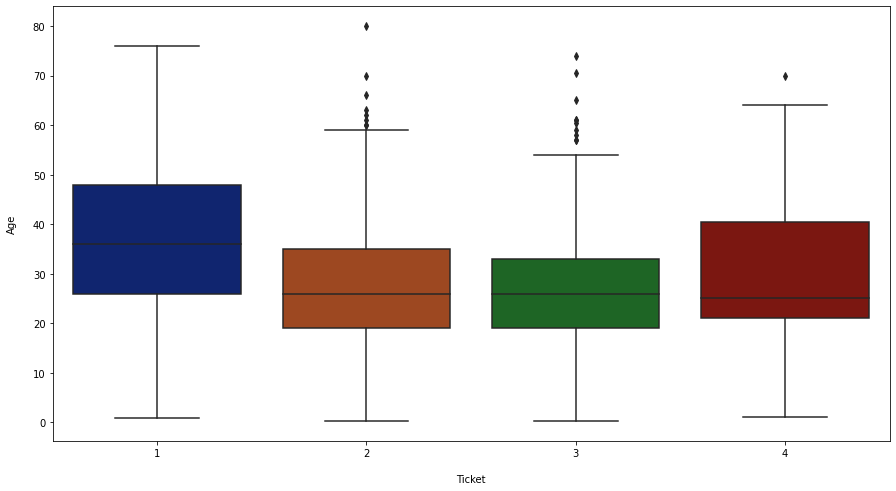

In [57]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Ticket',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nTicket')
plt.ylabel('Age\n')
plt.show()

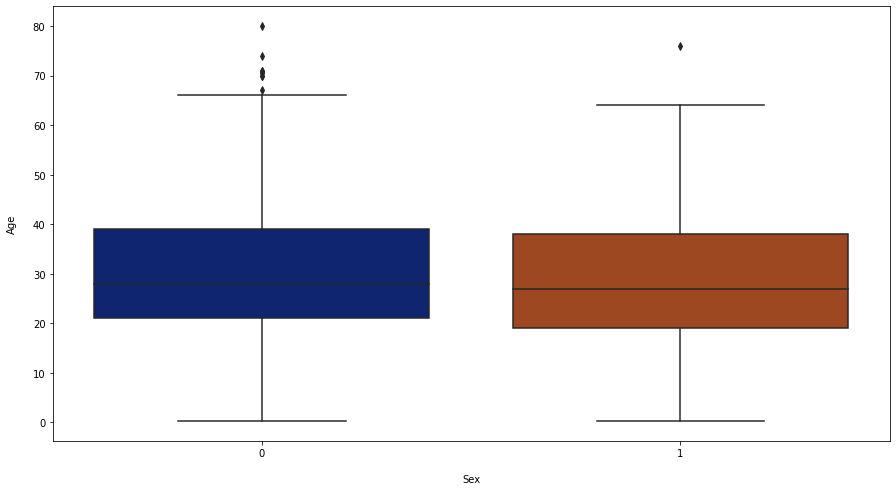

In [58]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Sex',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nSex')
plt.ylabel('Age\n')
plt.show()

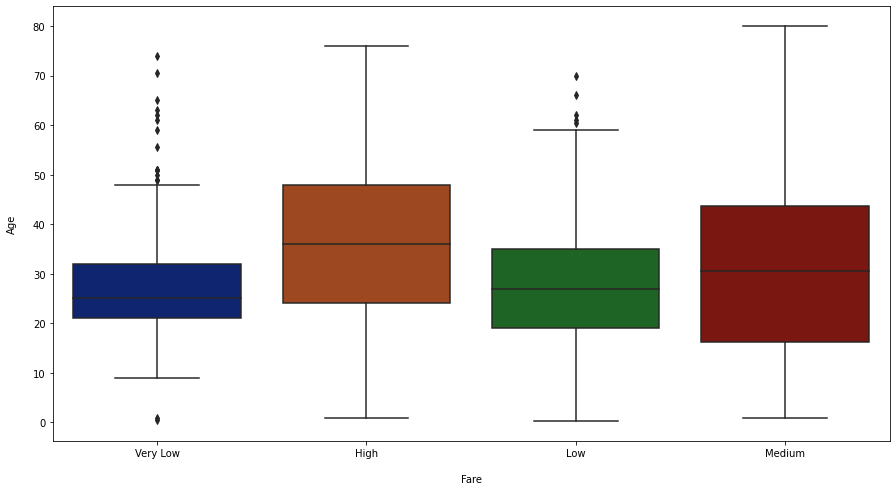

In [59]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Fare',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nFare')
plt.ylabel('Age\n')
plt.show()

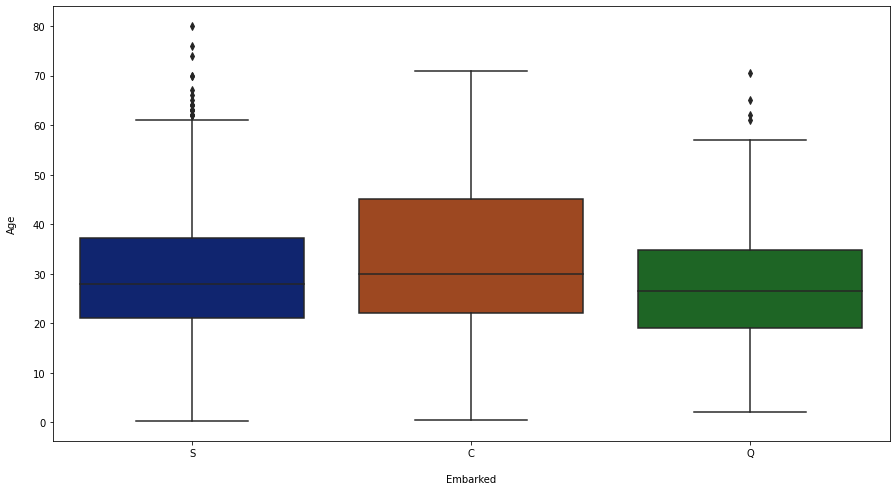

In [60]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Embarked',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nEmbarked')
plt.ylabel('Age\n')
plt.show()

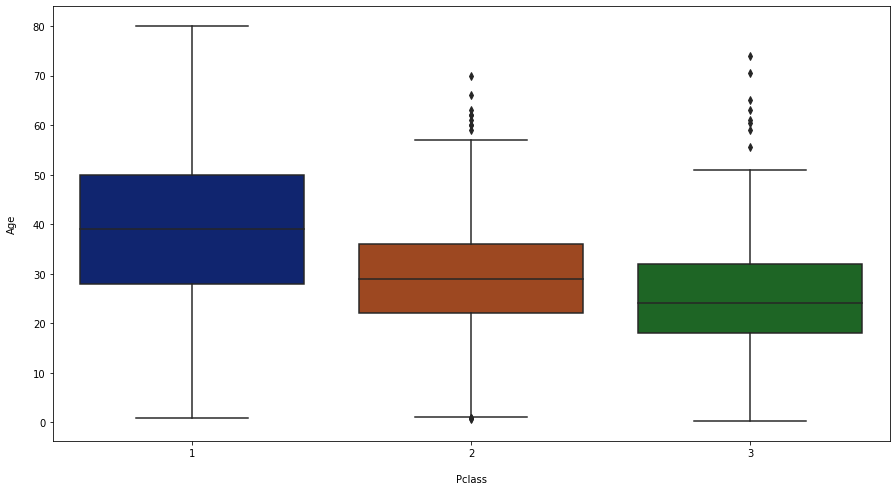

In [61]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Pclass',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nPclass')
plt.ylabel('Age\n')
plt.show()

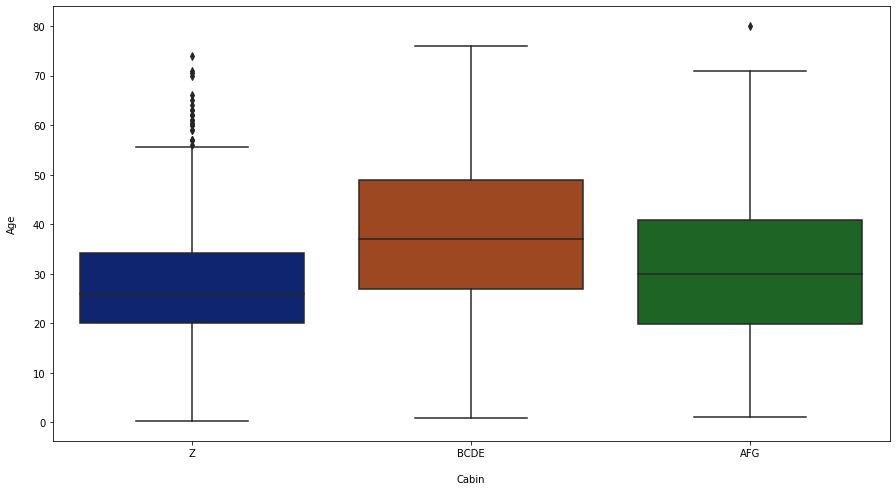

In [62]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Cabin',data=dataset,y='Age', palette = "dark")
plt.xlabel('\nCabin')
plt.ylabel('Age\n')
plt.show()

> With the boxplots results we can say that Pclass and Title are important to calculate the age.

> So we can calculate the median of the age grouped by these features.

In [63]:
medians = pd.DataFrame(dataset.groupby(['Pclass', 'Title'])['Age'].median())
medians

Age
Pclass Title      
1      Miss   30.0
       Mr     41.5
       Mrs    45.0
       Other  42.0
2      Miss   20.0
       Mr     30.0
       Mrs    30.5
       Other  15.5
3      Miss   18.0
       Mr     26.0
       Mrs    31.0
       Other   6.0

> Let's separate the dataset indexes that have **Age** nan values.

> By creating list of medians based on variables values it's possible to replace nan's safely.

In [66]:
ages = []
for i in dataset[dataset.Age.isnull() == True][["Pclass","Title"]].values:
    ages.append(medians.loc[(i[0],  i[1])].Age)
    
dataset.Age[dataset.Age.isnull() == True] = ages

> Doing the same for Train and Test.

In [67]:
index = dataset[dataset.Age.isnull() == True].index
train_idx = index[index <= 890]
test_idx = index[index > 890]

train['Age'][train.index.isin(train_idx)] = dataset['Age'][dataset.index.isin(train_idx)].values
test['Age'][test.index.isin(test_idx - 891)] = dataset['Age'][dataset.index.isin(test_idx)].values

> Now that we have all ages, it's easy to group them into categories.

In [68]:
ages = []
for i in dataset.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

dataset.Age = ages

ages = []
for i in train.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

train.Age = ages

ages = []
for i in test.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

test.Age = ages

> Let's now see the probabilities for each category.

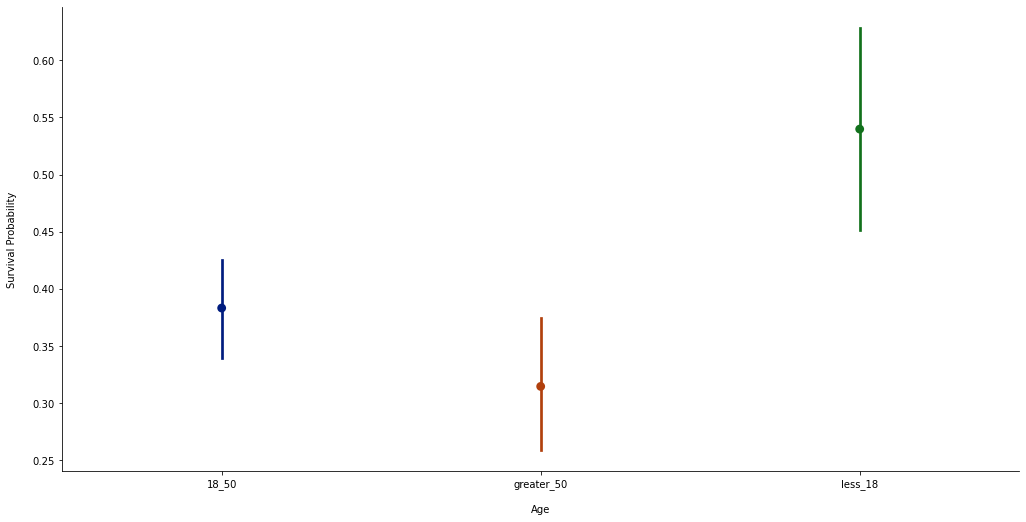

In [69]:
sns.factorplot(x='Age', 
               size= 7, 
               aspect= 2,
               data=train, 
               y ='Survived',
               palette = "dark")
plt.xlabel('\nAge')
plt.ylabel('Survival Probability\n')
plt.show()

> Children and teenagers have more probability to survive.

### Splitting variables into train and test sets

In [70]:
# PassengerId is not relevant and Sex (we don't want this variable to get dummied - see next cell)
x_train = train.loc[:, ~train.columns.isin(['PassengerId', 'Survived', 'Sex'])]
y_train = train.Survived
x_test = test.loc[:, ~test.columns.isin(['PassengerId', 'Survived', 'Sex'])]

In [72]:
x_train.head()

,Pclass,Age,Ticket,Fare,Cabin,Embarked,Family,Title
0,3,18_50,2,Very Low,Z,S,Medium,Mr
1,1,18_50,1,High,BCDE,C,Medium,Mrs
2,3,18_50,3,Very Low,Z,S,Single,Miss
3,1,18_50,1,High,BCDE,S,Medium,Mrs
4,3,18_50,3,Very Low,Z,S,Single,Mr


In [73]:
mae = pd.read_csv("titanic_total.csv")

In [74]:
mae.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck,countDeck,Title,port_sex,Age_bin,FamilySize,Ticket_freq
0,1,0,3,male,1,0,7,S,U,1014,Mr,623,2,Small,1
1,2,1,1,female,1,0,71,C,C,94,Mrs,113,7,Small,2
2,3,1,3,female,0,0,7,S,U,1014,Miss,293,4,Alone,1
3,4,1,1,female,1,0,53,S,C,94,Mrs,293,6,Small,2
4,5,0,3,male,0,0,8,S,U,1014,Mr,623,6,Alone,1


In [75]:
t = pd.read_csv("new_train_final.csv")

In [87]:
t["21"].value_counts()

-0.208148    854
 4.804277     37
Name: 21, dtype: int64

In [91]:
count = sum([+1 for i in t["21"].values if i == t["21"].mode()[0]])

In [92]:
count

854

In [98]:
def single_value_dominate(df, target):
    remove_cols = []
    df_cols = df.drop(target, axis = 1)
    for col in df_cols:
        count= 0
        count = sum([+1 for i in t[col].values if i == t[col].mode()[0]])
        if count/t[col].shape[0] >= 0.95:
            remove_cols.append(col)
    return remove_cols

In [99]:
single_value_dominate(t, "Survived")

['21', '9', '14', '20', '10', '8']

In [94]:
t.columns

Index(['poly46', 'poly39', 'port_sex', '15', '21', 'Survived', '7', 'poly50',
       '6', '9', '14', '2', 'poly34', '20', '22', '10', '8', '16', '17',
       'poly18', 'poly41', 'poly40'],
      dtype='object')

> Transforming each category of each column into another column with 1 or 0 value (get_dummies).

In [ ]:
x_train = pd.get_dummies(x_train)
x_train["Sex"] = train.Sex # adding sex
x_test = pd.get_dummies(x_test)
x_test["Sex"] = test.Sex # adding sex

# 2-Features Importance

> Lets see the most important features with the Random Forest Classifier.

In [ ]:
rf = RandomForestClassifier() 
rf.fit(x_train, y_train)

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
plt.plot(feature_importances)
plt.scatter(y=feature_importances.importance,x=feature_importances.index)
plt.ylabel('Importance\n')
plt.grid()
plt.show()

> It seems that '**Sex**' and '**Mr**' are the most important variables.

# 3-Train Model

> Here we are going to try some models.

### Adaboost

In [ ]:
ABC = AdaBoostClassifier(DecisionTreeClassifier())

ABC_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[5,6,7,8,9,10,20],
                  "learning_rate":  [0.001, 0.01, 0.1, 0.3]}

gsABC = GridSearchCV(ABC, param_grid = ABC_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsABC.fit(x_train,y_train)

ada_best = gsABC.best_estimator_

gsABC.best_score_

### ExtraTress

In [ ]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [3, 4, 5],
                 "max_features": [3, 10, 15],
                 "min_samples_split": [2, 3, 4],
                 "min_samples_leaf": [1, 2],
                 "bootstrap": [False,True],
                 "n_estimators" :[100,200,300],
                 "criterion": ["gini","entropy"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsExtC.fit(x_train,y_train)

ext_best = gsExtC.best_estimator_

gsExtC.best_score_

### Random Forest

In [ ]:
rf_test = {"max_depth": [24,26],
           "max_features": [6,8,10],
           "min_samples_split": [3,4],
           "min_samples_leaf": [3,4],
           "bootstrap": [True],
           "n_estimators" :[50,80],
           "criterion": ["gini","entropy"],
           "max_leaf_nodes":[26,28],
           "min_impurity_decrease":[0.0],
           "min_weight_fraction_leaf":[0.0]}

tuning = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_test, scoring = 'accuracy', n_jobs = 6, cv = 10)

tuning.fit(x_train,np.ravel(y_train))

rf_best = tuning.best_estimator_

tuning.best_score_

### GBM

In [ ]:
GBM = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [450,460,500],
                 'learning_rate': [0.1,0.11],
                 'max_depth': [7,8],
                 'min_samples_leaf': [30,40],
                 'max_features': [0.1,0.4,0.6]}

gsGBC = GridSearchCV(GBM, param_grid = gb_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsGBC.fit(x_train,y_train)

gbm_best = gsGBC.best_estimator_

gsGBC.best_score_

### SVC

In [ ]:
SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.027,0.029,0.03,0.031],
                  'C': [45,55,76,77,78,85,95,100],
                  'tol':[0.001,0.0008,0.0009,0.0011]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsSVMC.fit(x_train,y_train)

svm_best = gsSVMC.best_estimator_

gsSVMC.best_score_

### XGBoost

In [ ]:
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1,0.04,0.01], 
                  'max_depth': [5,6,7],
                  'n_estimators': [350,400,450,2000], 
                  'gamma': [0,1,5,8],
                  'subsample': [0.8,0.95,1.0]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(x_train,y_train)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

## Models Correlations

> This is a correlation between the models predictions. With the results we can see if its possible to combine them into a Voting Classifier.

In [ ]:
corr = pd.concat([pd.Series(rf_best.predict(x_test), name="RF"),
                              pd.Series(ext_best.predict(x_test), name="EXT"),
                              pd.Series(svm_best.predict(x_test), name="SVC"), 
                              pd.Series(gbm_best.predict(x_test), name="GBM"),
                              pd.Series(xgb_best.predict(x_test), name="XGB"),
                              pd.Series(ada_best.predict(x_test), name="ADA")],axis=1)

plt.figure(figsize=(18,18))
sns.heatmap(corr.corr(),annot=True)
plt.show()

# 4-Voting Classifier

> We can use a Voting Classifier to ensemble all the models and to build a powerfull one.

In [ ]:
voting = VotingClassifier(estimators=[('rfc', rf_best), 
                                      ('extc', ext_best),
                                      ('svc', svm_best),
                                      ('gbc',gbm_best),
                                      ('xgbc',xgb_best),
                                      ('ada',ada_best)])

v_param_grid = {'voting':['soft',
                          'hard']} # tuning voting parameter

gsV = GridSearchCV(voting, 
                   param_grid = 
                   v_param_grid, 
                   cv = 10, 
                   scoring = "accuracy",
                   n_jobs = 6, 
                   verbose = 1)

gsV.fit(x_train,y_train)

v_best = gsV.best_estimator_

gsV.best_score_

# 5-Submission

> Finally, it's time to test the model in the test set and make the submission.

In [ ]:
pred = v_best.predict(x_test)

submission = pd.DataFrame(test.PassengerId)
submission["Survived"] = pd.Series(pred)

In [ ]:
submission.to_csv("submission.csv",index=False)

### If you made this so far, let me know if you have questions, suggestions or critiques to improve the model.